In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Read QDM data

First, we create a read the observation points.

In [2]:
nc_file = "NRM1.mat"
data_dir = pathlib.Path("")/"real-data"
data = mg.load_qdm(data_dir / nc_file)

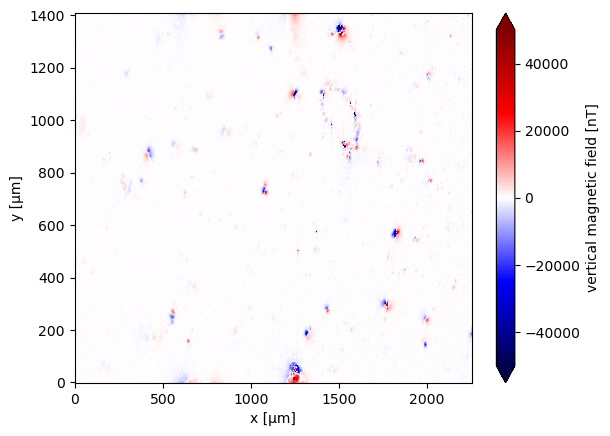

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

In [4]:
# copy data sets
data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [5]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 9MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB -201.2 -232.0 -234.8 ... -120.2 -138.4 -170.5

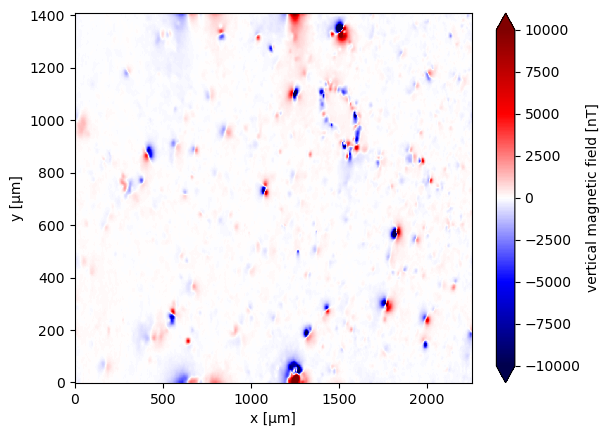

In [6]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [7]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB -201.2 -232.0 -234.8 ... -120.2 -138.4 -170.5
    tga      (y, x) float64 5MB 16.68 32.37 29.18 3.798 ... 25.15 19.51 14.49
    x_deriv  (y, x) float64 5MB -13.11 -7.147 3.456 ... -3.639 -10.71 -13.69
    y_deriv  (y, x) float64 5MB 2.946 5.673 3.255 -1.761 ... 11.15 8.54 2.433
    z_deriv  (y, x) float64 5MB 9.88 31.06 28.79 0.1939 ... -22.25 -13.9 4.101

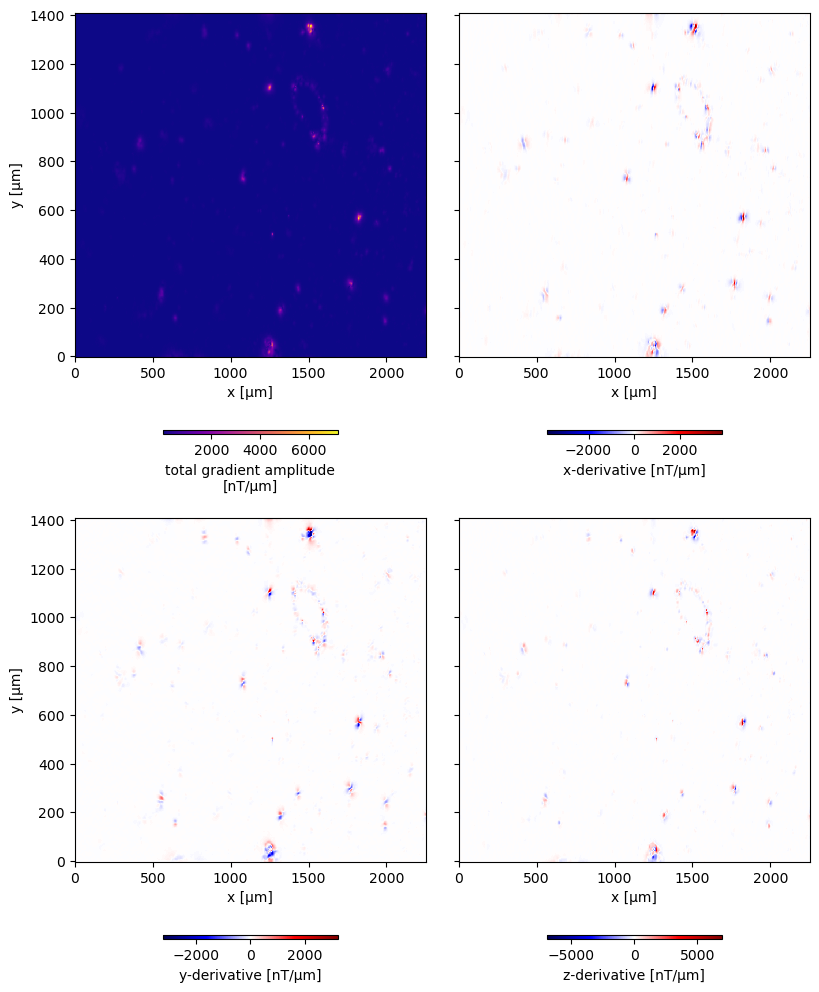

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [9]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

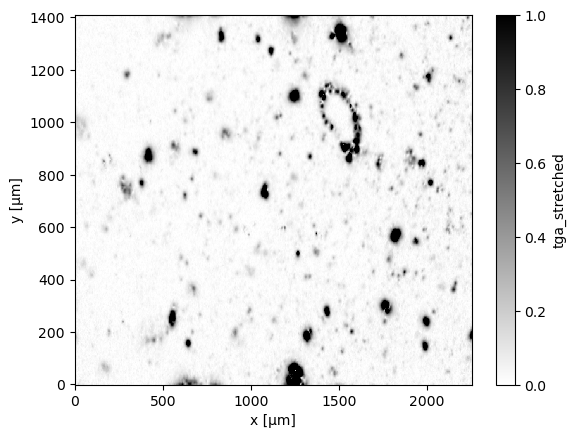

In [10]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [11]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 100],
    size_increment=1.0,
    threshold=0.05,
    overlap=1.0,
    exclude_border=30,
    nsizes=20,
)

end_detection_time = time.perf_counter()

In [12]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

231 potential sources detected within 1.9304 seconds


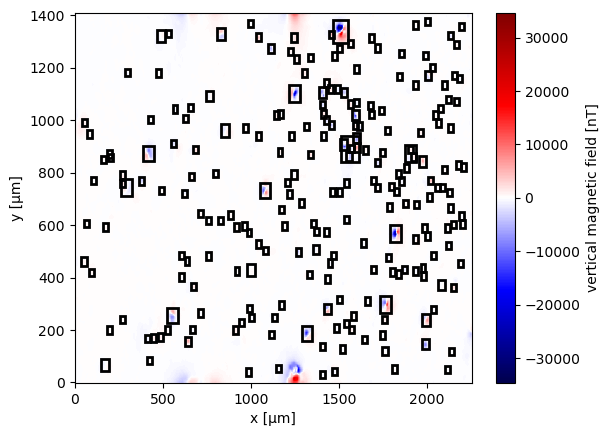

In [13]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [14]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#    bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [15]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

231 euler positions and dipole moments estimated within 2.0191 seconds


# Iterative Euler deconvolution

In [16]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [17]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

In [18]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

base_levels_itr_euler = []
#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    base_levels_itr_euler.append(base_level)
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2


    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [19]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 58.6986 seconds


In [20]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x       y     z          bz    z_deriv
0  1793.05  538.15  10.0 -338.834303 -41.295485
1  1795.40  538.15  10.0 -375.661347 -45.975635
2  1797.75  538.15  10.0 -405.124436 -55.490629
3  1800.10  538.15  10.0 -427.888951 -62.634882
4  1802.45  538.15  10.0 -442.481715 -64.716839

In [21]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])

In [22]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

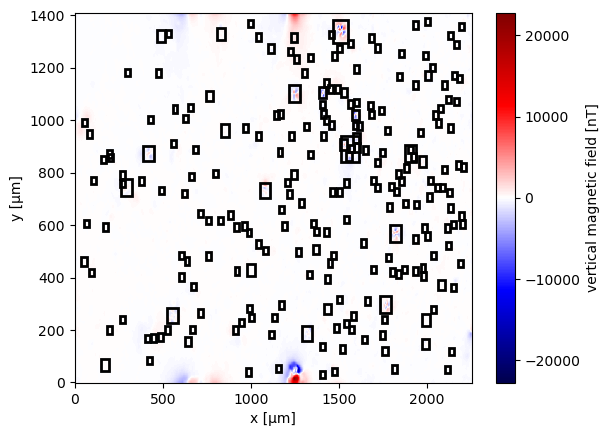

In [23]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


# Comparison plots

## Euler comparison

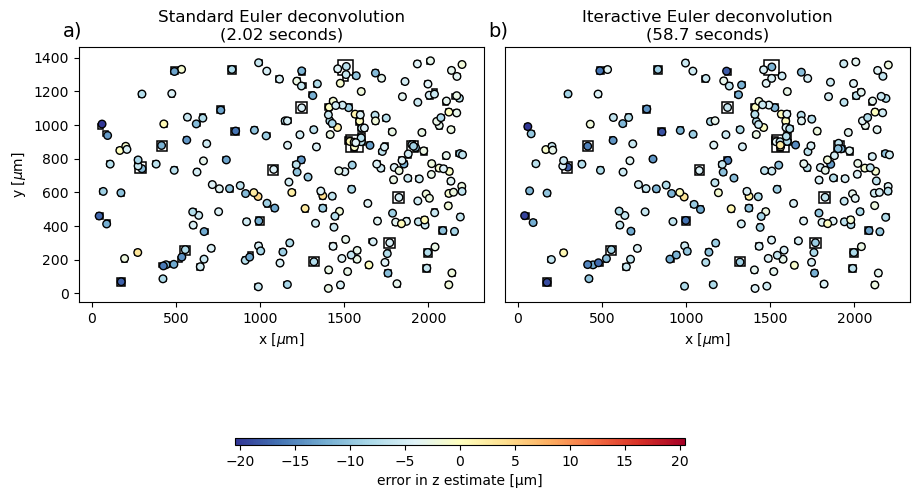

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((positions[2]))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

In [25]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

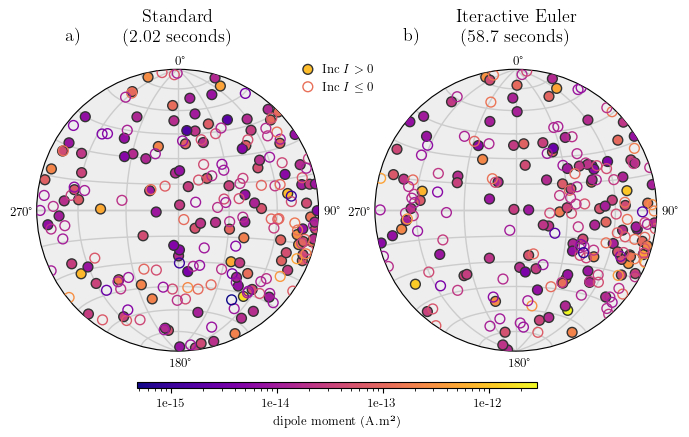

In [26]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

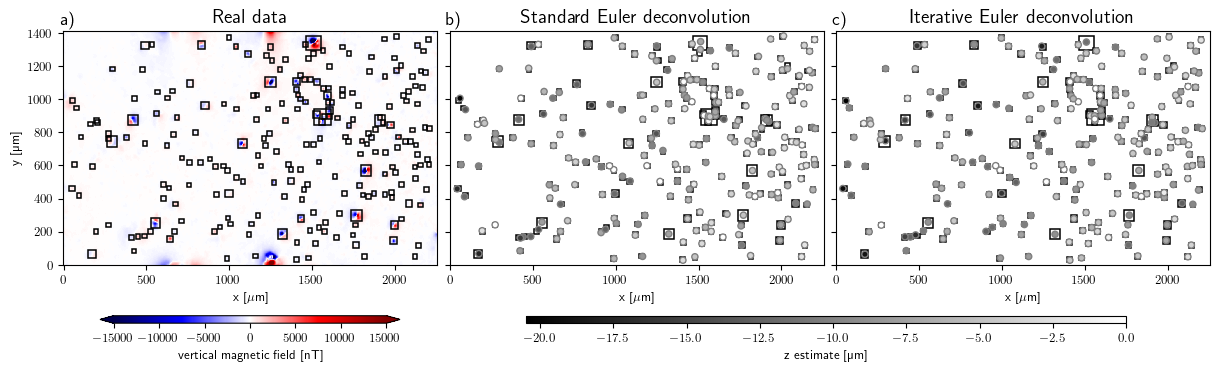

In [27]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir/"euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


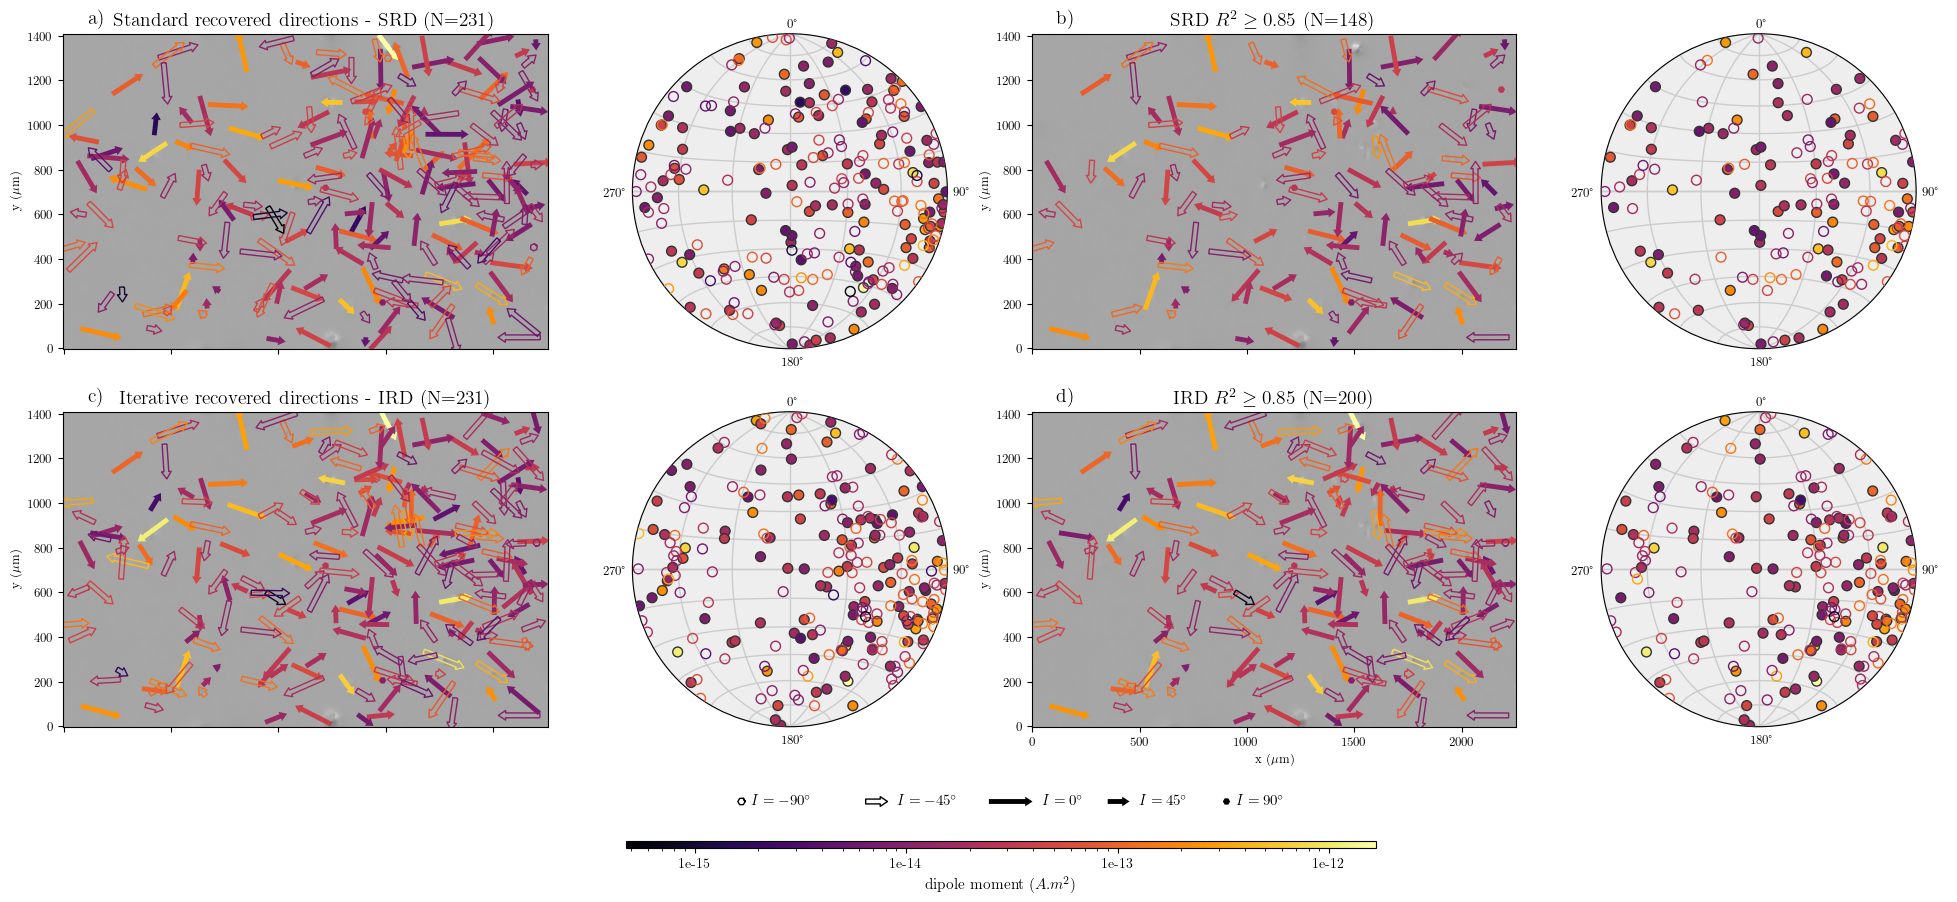

In [28]:
import warnings
warnings.filterwarnings('ignore')

r_square_filter = 0.85

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)   

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r_square_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r_square_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir/"real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    # fig.savefig("real-data-stereograms.pdf", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

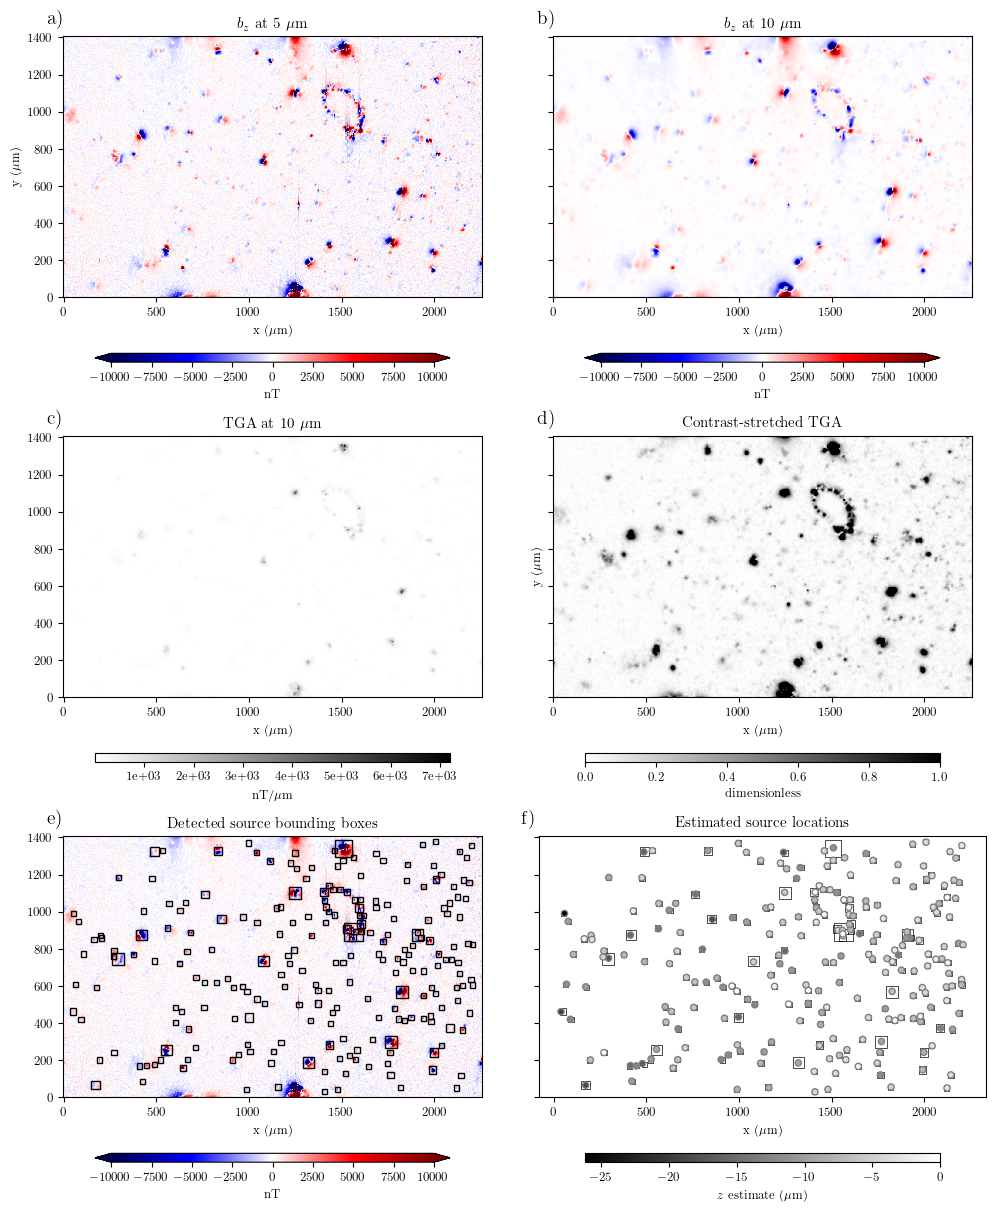

In [29]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("equal")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
        
    ax = axes[5]  
    ax.set_aspect("equal")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions_itr[2])
    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=-10)
    
    # fig.savefig("processing_steps.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

In [47]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


In [48]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB -201.1 -231.6 -234.2 ... -121.2 -139.2 -171.0
    tga      (y, x) float64 5MB 16.6 32.34 29.18 3.804 ... 25.07 19.4 14.43
    x_deriv  (y, x) float64 5MB -12.99 -7.05 3.525 3.412 ... -3.564 -10.6 -13.56
    y_deriv  (y, x) float64 5MB 3.038 5.761 3.342 -1.672 ... 11.27 8.657 2.539
    z_deriv  (y, x) float64 5MB 9.881 31.03 28.77 0.1827 ... -22.1 -13.75 4.22

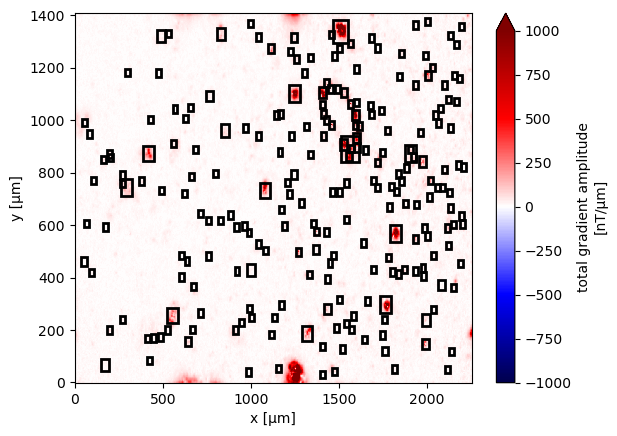

In [49]:
ax = plt.subplot(111)
scale=1000
data_up_copy.tga.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [50]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [57]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.05,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [58]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows_new)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

287 potential sources detected within 1.3524 seconds


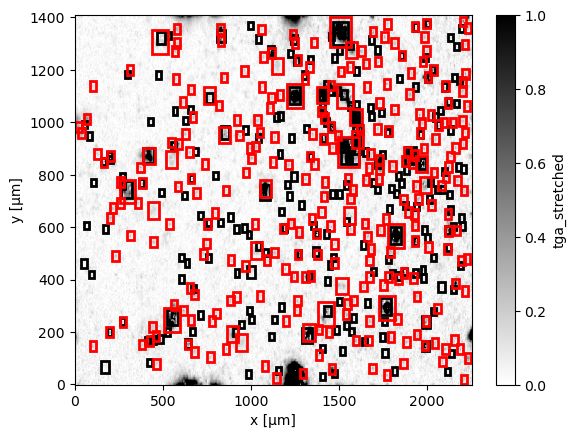

In [59]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [60]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[1278.81522369 1315.58477631   23.91522369   60.68477631]
[2216.46522369 2253.23477631   82.66522369  119.43477631]
[545.61522369 582.38477631 284.76522369 321.53477631]
[1579.61522369 1616.38477631  148.46522369  185.23477631]
[ 19.21522369  55.98477631 940.41522369 977.18477631]
[181.36522369 218.13477631 616.11522369 652.88477631]
[1913.31522369 1950.08477631  587.91522369  624.68477631]
[1882.76522369 1919.53477631 1088.46522369 1125.23477631]
[1523.21522369 1559.98477631  249.51522369  286.28477631]
[1927.41522369 1964.18477631  171.96522369  208.73477631]
[1636.01522369 1672.78477631  761.81522369  798.58477631]
[1003.86522369 1040.63477631  592.61522369  629.38477631]
[1196.56522369 1233.33477631  820.56522369  857.33477631]
[1008.56522369 1045.33477631  888.71522369  925.48477631]
[1657.16522369 1693.93477631  223.66522369  260.43477631]
[1675.96522369 1712.73477631 1328.16522369 1364.93477631]
[1925.06522369 1961.83477631  317.66522369  354.43477631]
[

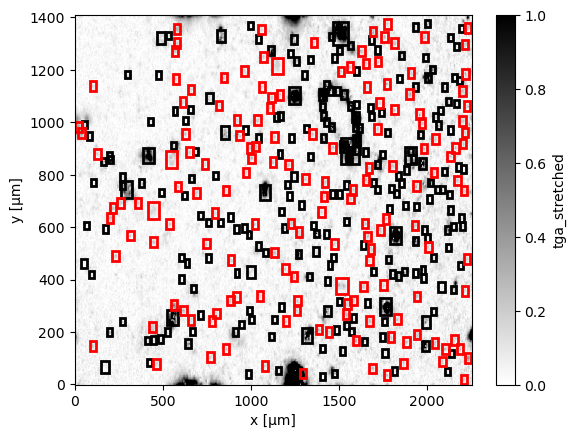

In [61]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [62]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))
base_levels_itr_euler_enhanced = list(np.copy(base_levels_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    base_levels_itr_euler_enhanced.append(base_level)
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[1278.66524516   42.18522637  -13.25501473]

[ 2.75272147e-13 -5.42341207e-13 -6.06293825e-13]

(44.910015008069514, 153.08935151890304, 8.587787501183203e-13)

0.9845387142523757

[2240.71018913   98.63581578  -12.216257  ]

[ 5.67598275e-14 -1.27231930e-14 -1.19193169e-14]

(11.580214410818495, 102.63447948804534, 5.937699701105727e-14)

0.9918546342375634

[567.76744716 298.3055541   -5.55987334]

[-1.27274228e-14  1.58724797e-14  5.12048980e-15]

(-14.126898258287767, -38.724547005123206, 2.0979569044959298e-14)

0.8138855715245086

[1598.97499668  165.67651289   -4.16544782]

[ 5.79510809e-15 -7.76394119e-17 -3.34917530e-15]

(30.022741304175828, 90.76756885959382, 6.693749385984015e-15)

0.850019399976095

[ 45.86892773 960.33855442 -27.70518131]

[-2.41576807e-13  8.51924390e-14  1.46446539e-13]

(-29.7567391680725, -70.57472201168841, 2.95065576165078e-13)

0.9709997019876411

[196.77438459 637.99299946 -13.93088839]

[ 4.15541996e-14 -2.96556599e-14  1.21503533e-14]

(-13.387549768297339, 125.51401378766242, 5.247704981434095e-14)

0.9931817803781605

[1933.69351189  603.21182748   -7.79506102]

[ 9.81719582e-15 -8.95188153e-15 -4.85024684e-15]

(20.055566521800042, 132.36035106029362, 1.414349359411529e-14)

0.9227583488199125

[1904.38970639 1100.42698731  -16.19895198]

[ 2.15733497e-14 -6.21516108e-14 -2.56398486e-14]

(21.292191799411427, 160.85767974022602, 7.06090219151396e-14)

0.9403128004383029

[1538.48663847  271.20693616  -14.11171251]

[ 4.07581159e-14 -1.61346156e-14  1.64215912e-14]

(-20.53688762649926, 111.59676239995842, 4.681045276733789e-14)

0.9778451898973307

piorou

[ 1.94741294e+03  1.88078838e+02 -8.84082233e-01]

[-5.40528529e-16 -8.95320686e-18  2.05925031e-15]

(-75.29040850022206, -90.94894909793433, 2.1290286767227626e-15)

0.42155498329012897

[1658.34156209  778.18705164   -6.31289975]

[ 9.41175689e-15 -6.10474599e-15 -1.59892199e-15]

(8.11165779519374, 122.96864375816756, 1.133162136589466e-14)

0.9481246621270197

[1023.44013969  612.27186431    2.55246247]

[-8.15224399e-17 -5.09240624e-16  3.50516858e-16]

(-34.20233634537834, -170.9049027641353, 6.235655455796072e-16)

0.6123854645466762

[1211.32585145  842.20012469   -7.83357072]

[ 6.70576461e-15 -6.90099243e-15  6.76244582e-15]

(-35.09878616321716, 135.82201532083562, 1.1761022441764741e-14)

0.9552633003385416

[1028.02759448  904.83393418  -19.03543298]

[ 2.13133432e-14 -1.96178528e-14 -6.45833070e-14]

(65.84233771539688, 132.62799654934173, 7.078221729518987e-14)

0.977944627498668

[1675.67982039  240.36983143  -10.79924555]

[-3.87466051e-15  2.16634260e-14  1.31908369e-14]

(-30.937933940777093, -10.140540420330261, 2.5657653797797056e-14)

0.9306805978248772

[1702.47077756 1348.57168288  -10.25152475]

[ 2.49605531e-14  2.22918197e-16 -7.85113144e-15]

(17.459874849543354, 89.48831533232071, 2.616713909491751e-14)

0.8626687150798826

[1946.48639316  334.20953937   -7.49402293]

[ 6.04938626e-15 -4.09373178e-15 -7.98827196e-15]

(47.560645993843366, 124.08694025601, 1.0824333832281188e-14)

0.8399312577240124

[1383.04454916  209.44026287   -2.50633763]

[-1.05614371e-15  1.79312308e-16 -3.33780445e-15]

(72.20613708758998, -80.36419407305027, 3.505500101567717e-15)

0.8496759824772205

[ 577.32408434 1346.90295425   -8.9119744 ]

[-1.14576984e-14 -1.69217520e-14 -5.53888575e-15]

(15.164966574068833, -145.89811721163989, 2.1173185791125814e-14)

0.7112153388213842

[1005.05014512  862.56660094   -6.45999146]

[ 6.89217098e-15 -5.90271501e-15 -4.64425830e-15]

(27.103362944667143, 130.57799537473468, 1.0193782440591684e-14)

0.8629397399738682

[1137.73893577  502.46982133  -12.06528072]

[-1.81383944e-14 -3.49320149e-15  1.41040060e-14]

(-37.363420837577884, -100.90090548031286, 2.3240628061113627e-14)

0.9631712495081951

[884.09272603 318.59281067  -5.47107499]

[4.35653612e-15 6.89053833e-15 1.18248972e-15]

(-8.25324892214372, 32.303080894460656, 8.237548628616636e-15)

0.9576412018372121

[1629.38927858 1271.32619778   -6.18575642]

[ 1.10557643e-14 -4.41552741e-16 -2.45739846e-15]

(12.521915242247116, 92.28710283021411, 1.1334182830085013e-14)

0.9333938385481323

[1122.5025599  1095.95470461   -3.7001984 ]

[ 2.88596781e-15  1.02585651e-15 -2.78439375e-15]

(42.27331655259576, 70.43155158998259, 4.139328484303032e-15)

0.9190649152908169

[232.89825588 490.64213613  -6.68851281]

[ 3.43400525e-15  8.64895108e-16 -6.42565787e-15]

(61.14037773776691, 75.86339649837541, 7.336859997981793e-15)

0.9639740548444734

[ 573.15862977 1276.62197481   -8.53945914]

[-1.77530399e-14 -1.60228511e-15  2.84316495e-15]

(-9.06248485730274, -95.15720761004282, 1.8050521626978194e-14)

0.8886028651568587

[625.76815091 956.892006    -3.40134983]

[ 3.06524639e-16 -1.77662412e-15  3.20987335e-15]

(-60.67861094171572, 170.21101188665403, 3.6815265212667106e-15)

0.9261299502697191

[1963.45382761 1031.85713406   -7.36756152]

[ 9.19618828e-15  2.36222858e-15 -5.35438071e-15]

(29.420021778918155, 75.59387014932015, 1.0900430974912515e-14)

0.8885897982954692

[450.04441153 541.95318434  -6.0272459 ]

[-8.19376720e-15  1.33756658e-15  3.57594295e-15]

(-23.30256654173668, -80.72870141592769, 9.039594749964333e-15)

0.9577699288410609

piorou

[ 1.73106900e+03  5.84292137e+02 -1.64111832e-01]

[-1.42455699e-15  2.89286364e-16  7.52355514e-16]

(-27.36468553023531, -78.52097420192757, 1.6367919944718688e-15)

0.32161503349547327

piorou

[2.23715298e+03 1.36029146e+03 9.56987298e-01]

[-6.85678004e-16  8.61808460e-16  5.06794066e-16]

(-24.71079071592531, -38.506701856926085, 1.2123152940141986e-15)

0.2516715033962936

[623.24531849 285.07534212  -9.66727944]

[-1.07074260e-14 -1.48720367e-14  8.51680724e-15]

(-24.926647746261665, -144.2472303930049, 2.02079799134022e-14)

0.9107934917190357

[1639.91896022  372.61193639   -6.38154859]

[-3.99520981e-15  6.37449114e-15  4.87980092e-15]

(-32.969424164421376, -32.077412834395886, 8.96706728427451e-15)

0.9429696654159586

[1691.77777943   56.25704668   -8.89684947]

[-1.98306629e-15  1.02736925e-14  7.30031514e-15]

(-34.90366064591593, -10.925083775888687, 1.2758366288070528e-14)

0.8851172030251291

[1660.41563459  564.24923999  -11.2191178 ]

[ 2.60047474e-14 -9.49576824e-16  8.15858006e-15]

(-17.40752794778342, 92.09125592434847, 2.7271065442638545e-14)

0.9873211752911696

[1128.3113369   848.24481454   -5.95942013]

[ 3.67183687e-15  4.83958007e-16 -4.64444883e-15]

(51.43031577833213, 82.49154092316515, 5.9403288051774884e-15)

0.936552986011918

[2109.06911426  135.43184134   -6.17106131]

[ 9.29049671e-15 -2.22264136e-15 -9.11538834e-16]

(5.4507988205270825, 103.45445338696297, 9.596059963268062e-15)

0.9033603040605005

[1977.12587249  994.26090702   -8.08120406]

[-1.03639692e-14 -4.31555216e-16  6.27794120e-15]

(-31.183262917458407, -92.38441625095575, 1.2124794520247653e-14)

0.8759693355438425

[1038.82130261 1006.8534729   -12.70897631]

[ 3.03964271e-14  3.92454503e-15 -3.51683222e-16]

(0.6574196737956071, 82.64312378041109, 3.065075064704968e-14)

0.9486336308802366

[1529.53852711  372.49574614   -5.78754034]

[ 7.93485606e-15 -7.20843335e-15 -4.50670395e-15]

(22.80150722378193, 132.2536300743641, 1.162900823321244e-14)

0.6052804562176775

[692.39459934 734.37009369 -11.35845568]

[ 1.83173183e-15  1.05566450e-14 -1.32693724e-14]

(51.08078654601687, 9.843645444409894, 1.705503561543203e-14)

0.9557893826150645

piorou

[1104.93950837 1064.84041545   -7.49517993]

[ 7.03304978e-15 -9.48270844e-15  1.88261377e-16]

(-0.9135623303028483, 143.43674426547358, 1.1807666616986475e-14)

0.4950097303906007

[2172.36244231  779.93130638   -3.30562766]

[-4.85504433e-15 -5.35614935e-16 -1.22086758e-15]

(14.03340192130526, -96.2954884542479, 5.034764782177708e-15)

0.9003686384643004

[1987.33101038 1328.17153321   -6.6027975 ]

[-3.20818493e-15 -8.27114549e-15  4.80535385e-15]

(-28.442599165323536, -158.79988545176258, 1.0089386692183907e-14)

0.9627503310988289

[ 573.42115721 1168.21150898   -8.91869936]

[-8.98187101e-15 -1.16407139e-14  3.52968247e-15]

(-13.499218874146303, -142.34654254881025, 1.5120809676747595e-14)

0.9712313402894204

piorou

[2203.17416539 1001.16037592   -3.13321233]

[ 2.84856004e-15 -4.03950981e-15  2.73240162e-16]

(-3.1640726743386223, 144.80947834551702, 4.950413520234789e-15)

0.6138189511675991

[220.77826793 673.89445392  -9.63056452]

[-1.53852781e-14 -4.52663435e-15  8.32091525e-15]

(-27.42233437978306, -106.39486165927303, 1.8067507623374106e-14)

0.9807200750144723

[649.70206145 889.26468252  -8.46974914]

[-4.41532943e-15  1.07161756e-14 -4.96854919e-15]

(23.204197054058163, -22.392872695491576, 1.261023529685371e-14)

0.9857754266149347

[1462.81556271  902.57988128   -6.72092802]

[-7.44041770e-15 -1.01089470e-15 -4.94459715e-15]

(33.36526508335476, -97.7371336995418, 8.990593115457608e-15)

0.958328318128982

[ 848.58589553 1169.42613325   -7.05227955]

[-3.41110491e-16  4.86183623e-15  5.86591879e-15]

(-50.27798724865738, -4.013343095578456, 7.626454691037806e-15)

0.8340204009606256

[1805.47180216  833.11892278   -3.01784949]

[-4.69232569e-15  5.78084036e-19  8.23578310e-16]

(-9.954929907870483, -89.99294128807861, 4.764053099591911e-15)

0.8566313916947236

[ 619.40912766 1079.89132526   -8.54702755]

[ 1.14871380e-14  1.02099857e-16 -5.11717380e-15]

(24.010690229909894, 89.4907576756424, 1.2575779550218246e-14)

0.8639322980910182

[1653.96757175 1224.48979503   -6.39471977]

[ 5.32501372e-16 -2.42642288e-15 -6.04249986e-15]

(67.65166314362344, 167.6221275659966, 6.533214386283185e-15)

0.8787491695732227

[1649.65116578  616.25319382   -6.1549321 ]

[-2.67389502e-15  4.90028890e-15 -4.26000708e-15]

(37.34804179044258, -28.619561706509295, 7.022122629639438e-15)

0.9631783435471889

[2211.04148992 1117.59717654  -11.67944108]

[-2.30293836e-14  2.20912542e-14  5.27197463e-15]

(-9.38073508471965, -46.191098180674615, 3.234454724415247e-14)

0.8582957343807747

[104.0097003  144.52076466 -10.05873651]

[ 1.60999937e-14 -3.61964131e-15 -5.04674904e-15]

(17.005150559587506, 102.67070476806909, 1.725634019309394e-14)

0.9644225688917409

piorou

[1884.41023377  162.74209369   -5.56094293]

[-3.93038430e-16  6.33515731e-17  6.92144814e-15]

(-86.70805972901803, -80.8435809342313, 6.932888066533139e-15)

0.7734595220286236

[1312.62241168  781.87742381   -9.3793612 ]

[-9.01590602e-15  1.05674132e-14  7.22839020e-15]

(-27.491079211287847, -40.470148982145076, 1.565906788700011e-14)

0.9665680698887057

[917.65909813 960.60217778  -4.74083288]

[-2.06459407e-16  1.92392515e-15 -2.44062866e-15]

(51.592031315270724, -6.125059580560418, 3.114607796399582e-15)

0.2729722380458215

[886.71576565 474.51310147  -1.60232734]

[ 2.89876791e-15  5.84833267e-17 -1.69671043e-16]

(3.349141652888178, 88.84420092928305, 2.9043181621011103e-15)

0.8593251883342359

[2047.3912413   936.23012487  -10.67825907]

[ 1.92660020e-15  1.63345788e-14 -6.86242722e-15]

(22.647094429483396, 6.7267372790725775, 1.7821985283539766e-14)

0.8509394200564815

[1816.98824559 1302.02958434   -8.52613934]

[4.48775677e-15 8.44740028e-15 6.87371416e-15]

(-35.70084854443292, 27.97987308560721, 1.177906951034705e-14)

0.7921346367971547

[1566.61755747 1207.05321905   -6.20390695]

[-3.21570188e-15  2.48675656e-15  5.21043316e-15]

(-52.039478644134746, -52.28461344831118, 6.6085785494940365e-15)

0.6735011323821164

[1348.30825008  950.50585066   -5.38389524]

[3.49481745e-15 5.21489424e-15 2.38843824e-15]

(-20.830169452133, 33.828441593180045, 6.716659005873592e-15)

0.9440839838364403

[1245.20215586  413.12414972   -6.00319034]

[-3.71321187e-15 -6.72552975e-15  2.55117184e-16]

(-1.9019567259480727, -151.0966049318193, 7.686727365224816e-15)

0.8035247955232689

[ 967.10020761 1194.46083157   -6.81794668]

[ 7.27006525e-15 -5.67042673e-15 -1.55686445e-15]

(9.5844462387095, 127.95313247240789, 9.350476722749277e-15)

0.9111904544625216

[1585.96054789  312.80127172  -11.00756874]

[-1.28219270e-14  6.53887271e-15  1.04502155e-14]

(-35.98197465526948, -62.97951799391505, 1.7786671192243568e-14)

0.7976036852555555

[1267.08242024  313.77933295   -5.82637836]

[ 6.81901582e-15 -5.52878187e-15 -1.69728132e-15]

(10.9425429145741, 129.0347530929395, 8.941318110283e-15)

0.923997181193054

[535.1883195  607.40783822  -6.2889296 ]

[-4.14281629e-15 -5.44106764e-15 -3.38344451e-15]

(26.323808926231305, -142.71443874673056, 7.629930582191114e-15)

0.9342583538764524

[2047.26210422  156.01468289   -6.19472132]

[ 4.37614195e-16 -9.84525086e-15  2.17761547e-16]

(-1.2658369479576215, 177.4549197906774, 9.857377478323901e-15)

0.952490657560262

[1418.96007477  774.1305544   -15.9972145 ]

[-7.19095248e-15  1.98422209e-14 -2.94338582e-14]

(54.35821311248079, -19.920852366710502, 3.621844190768044e-14)

0.9507295271863914

[1049.39988111  340.64941986   -6.68742064]

[ 7.24805607e-15 -4.88211361e-15 -8.64810811e-16]

(5.651613702411823, 123.96324569798742, 8.78164265971025e-15)

0.9146309564277153

[1946.54884022  752.99831153   -8.56399592]

[ 9.74853421e-15 -5.79043891e-15 -7.62167386e-15]

(33.90860831783654, 120.70948457651747, 1.3662101396672177e-14)

0.8608669741927854

[1983.00016529  901.37102136   -4.45798126]

[ 4.90919470e-15 -4.07297158e-15  3.67673788e-16]

(-3.298868302372863, 129.68119968394737, 6.389403262893225e-15)

0.9195387110136978

[1763.1388027  1324.57484291   -6.81370397]

[ 5.94160056e-15 -2.01943180e-15 -5.22508754e-15]

(39.781759629643055, 108.77187513665943, 8.16592075779934e-15)

0.8406593318232627

[1201.35490424  250.83315123   -9.1009057 ]

[ 9.58821617e-15 -1.05575237e-14  2.98741471e-15]

(-11.830780203917058, 137.7546486035896, 1.4571199101084078e-14)

0.8438960558994284

[ 13.7996383  992.33687654 -14.99761111]

[ 5.09959520e-14 -3.80482516e-14 -1.47697257e-14]

(13.068826495357907, 126.72674348400811, 6.531769563249871e-14)

0.8085590063287708

[771.92698849 105.95267905  -6.6504117 ]

[-6.29115500e-15 -6.27673700e-15 -6.44809154e-16]

(4.149977102304098, -134.93426977207722, 8.910209728962978e-15)

0.8623337787825724

[466.09861563  78.11351892  -7.39951556]

[-1.12142242e-14 -1.93266442e-15  9.81350678e-16]

(-4.928886786709835, -99.77832587496297, 1.1421780351864788e-14)

0.9551361092320193

[ 920.82340346 1004.74366132   -5.60729571]

[-2.84841522e-15  6.85493651e-15  2.28477643e-15]

(-17.107809613217032, -22.56423246846689, 7.766841516850653e-15)

0.966321627893036

[354.48963989 702.71313039 -19.17895058]

[-5.76801281e-14  1.71191003e-14  4.73078094e-14]

(-38.177113179969005, -73.46944153279492, 7.653815784866838e-14)

0.912687043754495

[2222.85547302 1293.58101469   -9.37749215]

[ 1.01721762e-14 -1.08701841e-14  2.78424051e-15]

(-10.593095355551677, 136.89989384256435, 1.5145496546692046e-14)

0.8421938059073504

[1148.59508951 1220.03527204  -18.54528662]

[ 7.68546661e-14 -5.73375559e-14 -9.51113609e-15]

(5.664726273247014, 126.72484243994853, 9.63571311795397e-14)

0.9205887408993332

piorou

[2207.94385999  738.82302549   -2.73950382]

[4.71791225e-16 4.97664269e-16 2.11108101e-15]

(-72.00439827852185, 43.47124035073166, 2.2196665798939312e-15)

0.2480648392187056

[127.7815357  878.19212437  -7.18822738]

[ 1.47110629e-15 -4.96574911e-15 -5.21437165e-15]

(45.19457845042509, 163.49804405758113, 7.349318996232707e-15)

0.9581014811118351

[747.6422111  542.74219198  -5.79205995]

[-3.16648164e-15 -6.69776875e-15  1.88635940e-15]

(-14.285053879802831, -154.69677772957232, 7.644937145766004e-15)

0.8459951477388439

[1166.98782114 1101.65371553   -2.22903836]

[-7.10013338e-16 -2.33584141e-15 -1.20645044e-15]

(26.297200764396024, -163.0925795244964, 2.7231960413746498e-15)

0.8467304756224135

[1511.21973181 1189.0372873    -8.56670081]

[-3.54205459e-15 -1.12007676e-14 -2.42395500e-15]

(11.658690611602367, -162.4513163414091, 1.1994953261872208e-14)

0.8707790764401571

[316.60228228 573.33936059  -4.11583535]

[ 1.63167852e-15 -3.20453274e-15  7.45631058e-16]

(-11.714204947271584, 153.0157929914748, 3.6725155594793115e-15)

0.7826805627245614

piorou

[1772.85948176  631.13665669   -1.91103704]

[ 2.70041619e-15  3.22334802e-16 -8.85222176e-16]

(18.030011208654155, 83.19310348263593, 2.860028951639445e-15)

0.6225624158274434

[1222.09200326  614.53435942  -16.07711561]

[-4.47942473e-14  3.36992223e-14 -1.04476597e-14]

(10.557779462054835, -53.04543939984924, 5.702031010214229e-14)

0.9816013907559192

[1767.00791982 1153.94234808   -5.15219541]

[-5.55131726e-15  3.75526171e-15 -1.17379707e-15]

(9.933850925286837, -55.92309603027776, 6.804183524046907e-15)

0.6062667620996488

[1775.22875535   33.16200871   -3.67056867]

[-1.90745433e-15  1.05736293e-15  3.23435667e-15]

(-56.00833179576715, -60.99899522422543, 3.9009564780791695e-15)

0.8438404915779935

[1674.44101966  471.64763532   -1.85665969]

[-1.83260823e-15  1.64370976e-15  9.60896616e-16]

(-21.322193688339908, -48.11031714651876, 2.642642048359908e-15)

0.8468613593395584

[1673.25082311  822.62088413   -5.19768718]

[-4.29397000e-15  4.24827718e-15  2.83968990e-15]

(-25.179096864973463, -45.30647446175518, 6.674569354202339e-15)

0.7166230980839043

[444.96133892 665.9911681  -16.54369549]

[-3.74953271e-14 -4.63756953e-14 -6.94644647e-15]

(6.643775189825161, -141.04402934954933, 6.004046794653076e-14)

0.9416406282589118

[1083.37239894   68.206374     -4.92853208]

[-6.60938082e-15  6.76968227e-16  2.89031782e-16]

(-2.4909642680533084, -84.15185298593774, 6.65024361446793e-15)

0.8484269716266417

piorou

[ 2.22990254e+03  1.06137360e+03 -6.61519477e-01]

[-1.73035059e-15  4.63415779e-16  5.57902471e-16]

(-17.298977840370615, -75.00711405963311, 1.8761989553502564e-15)

0.5659842012975339

[1059.75678587 1133.0465468    -5.16068111]

[-6.91381402e-16 -3.61151758e-15 -3.26738980e-15]

(41.62358085969596, -169.16253789168098, 4.919034822545062e-15)

0.8336123644772708

[996.65222863 906.04424163  -5.17999706]

[ 1.86232398e-15  5.77628981e-15 -3.33212372e-15]

(28.768214203450665, 17.869754021736963, 6.923642328878367e-15)

0.9264016116065317

[ 2.08972056e+03  8.80636833e+01 -1.50659768e+00]

[ 1.02439709e-15 -2.11864821e-15 -1.02433193e-15]

(23.522199819730364, 154.1955604936578, 2.5665766205795838e-15)

0.849770007533006

[569.59929494 864.08918627 -25.08312374]

[ 1.95851607e-13 -9.36872051e-15 -2.09689049e-14]

(6.1041812589076105, 92.73870240736133, 1.971936101816887e-13)

0.7963704869804964

[1273.23968747  571.59524327  -11.62614584]

[-1.33954252e-14  2.47753610e-14  7.52345059e-15]

(-14.955795803740893, -28.398993445175133, 2.915232817518232e-14)

0.8757338377098224

piorou

[ 1.48035644e+03  5.37945151e+02 -1.07542135e+00]

[1.84148353e-15 8.84456788e-16 9.62925094e-17]

(-2.6986880471959203, 64.34522171538347, 2.045140005198928e-15)

0.5402144020528916

[584.49636199 756.21893336  -7.83066682]

[ 8.28642262e-15 -6.90003030e-15 -3.54477009e-16]

(1.8828284633232253, 129.783847543347, 1.0788923575283754e-14)

0.9814115836032863

[2154.21050247  165.71386346   -6.58603166]

[-3.68161663e-15 -2.84277197e-15 -4.98095022e-15]

(46.95940116340108, -127.67363910559979, 6.815094906024026e-15)

0.8230061588845415

[1912.91550072 1190.20512515   -7.59509705]

[ 1.15028772e-14 -6.92886211e-15  6.10759700e-16]

(-2.6041467875883715, 121.06303790534909, 1.3442408291106656e-14)

0.9483100536500099

[652.02144739 249.83523513  -7.37107755]

[-8.78085682e-15 -1.24696340e-15 -2.99917271e-15]

(18.68375189014508, -98.08249091075014, 9.36233951279236e-15)

0.8134496111408911

[  98.2545558  1135.59578847  -12.88981553]

[-3.73613086e-15 -4.51271045e-15 -1.41120562e-14]

(67.45427788356952, -140.37820671232325, 1.52798350369864e-14)

0.9622349421207359

[2166.35055242  894.84060526   -7.63216975]

[ 7.22591915e-15 -4.55955649e-15 -4.07424269e-15]

(25.49380081181357, 122.25193417539985, 9.465881704815178e-15)

0.7722544851393053

[2035.96293669  804.16951804   -8.92015219]

[-1.04019315e-14 -1.70336261e-14  6.56551903e-16]

(-1.8841073830743198, -148.5888223321281, 1.9969367933768563e-14)

0.9531941077860353

[1449.37620907  207.00018597   -8.75254715]

[-8.19139638e-15 -9.25326029e-15  4.26966087e-15]

(-19.059819892334534, -138.48332135713864, 1.3074853898106191e-14)

0.8432730714848888

[862.61696059 130.8671648   -3.50165471]

[ 1.01797712e-15 -2.33454735e-15 -1.79438240e-15]

(35.166715441367195, 156.4404376678442, 3.115477003146279e-15)

0.6676171606664077

[2008.14580075  524.33005411   -7.37575477]

[-4.53347545e-15  1.62678983e-15 -5.84613326e-15]

(50.51553979114779, -70.26001107456172, 7.574702564080263e-15)

0.8980980905715524

[1135.17174653  948.10571738   -5.46237426]

[ 2.59420855e-15  2.83180549e-15 -2.62220723e-15]

(34.324746239008874, 42.492706219861866, 4.650270000850408e-15)

0.7711061994725537

[1362.65925987 1311.1348231   -21.91138888]

[-6.06835761e-14  1.01048512e-14 -1.23096888e-14]

(11.315181137803991, -80.54601764469261, 6.273860743251563e-14)

0.8495570139796293

[2212.008393     23.16318761   -6.55669673]

[-2.97699595e-15  3.67508612e-15 -5.43537468e-15]

(48.9720112656069, -39.00913119640689, 7.205002479915375e-15)

0.8726546881773533

[1798.9917161   180.02614371   -8.88382058]

[ 4.77995382e-15 -1.34391815e-14 -3.36272927e-15]

(13.265301323628092, 160.42090122429352, 1.465494817187454e-14)

0.9381090735163181

[1554.85535739  306.99892238  -12.89760482]

[ 2.49193393e-14 -1.19693337e-14 -6.50007568e-15]

(13.231490151024966, 115.65604844492144, 2.839875709753123e-14)

0.924789126482491

piorou

[1715.32113375  983.71637868   -6.33152851]

[-1.47227631e-15  7.09496815e-15 -1.48216357e-15]

(11.560160013651931, -11.723066194298898, 7.396146256615646e-15)

0.35087426892005047

piorou

[1077.22241861 1242.38627705   -6.73247106]

[ 1.83954626e-15 -7.06112272e-15 -2.80854079e-15]

(21.051715368278458, 165.39801252844953, 7.818649870875308e-15)

0.41345247007860775

[ 578.36628251 1303.95290664  -16.12149413]

[-3.58128450e-14 -3.18679580e-14 -9.74954712e-15]

(11.495744478951833, -131.66419541262258, 4.892014192122969e-14)

0.972830462725234

piorou

[ 1.67184962e+03  5.09052608e+02 -9.67932775e-01]

[-1.11261999e-16  7.91019867e-16  2.97573047e-16]

(-20.431474884234635, -8.006492480916048, 8.524326253533183e-16)

0.06212596638791357

piorou

[ 667.11952313 1123.13271324   -6.38972831]

[ 4.37949832e-15 -3.59056765e-15 -2.08124464e-15]

(20.178445784562335, 129.3468946107947, 6.0335529260920815e-15)

0.4479375547474309

[2224.31513596  482.15115419   -6.73061329]

[ 4.7774934e-15 -3.7803382e-15  5.0237183e-15]

(-39.50930746711973, 128.35388771273688, 7.896400802760716e-15)

0.786635244147811

[1776.7382254  1371.83667515   -4.13351748]

[-1.91525469e-15 -3.20585675e-15 -2.16545758e-15]

(30.10807913024873, -149.14490588626614, 4.316818799657462e-15)

0.9243471970580183

[1398.4130768   658.74309261   -8.63791992]

[8.60194433e-15 2.06166898e-15 4.44910449e-15]

(-26.701300016212397, 76.52188773236063, 9.901437067073934e-15)

0.9736397249307569

[1843.81801687  251.56054597  -12.89624796]

[ 2.95213764e-14 -3.81979112e-15 -9.19680469e-15]

(17.168786527193944, 97.37257848449848, 3.115579700847157e-14)

0.8480434416498842

[2222.06228199 1178.25530949   -8.31983288]

[ 6.26892167e-15 -1.45036704e-14 -2.64746250e-15]

(9.51187088147972, 156.62455020432822, 1.6020764355797806e-14)

0.8296948814420448

[2218.584695    961.57619663   -4.92692525]

[ 1.71943258e-15 -5.64588396e-15  6.88825731e-16]

(-6.657015111534382, 163.0620843864301, 5.941963903764873e-15)

0.8156857853965279

[783.19814464 242.26604496  -8.50042652]

[ 7.37786930e-15 -5.79059015e-15 -2.44974834e-15]

(14.638472524665936, 128.1269294237343, 9.693562637796954e-15)

0.8575091373711982

[2211.95988408  919.55012523  -10.90006385]

[ 1.54614095e-14 -3.41523391e-15 -7.56601841e-15]

(25.539888434457072, 102.45591839578803, 1.7548892867847187e-14)

0.8636181610996974

[969.69587007 814.01868054  -6.30429532]

[-5.21478371e-15  3.02798528e-15 -2.48206367e-15]

(22.372516408296292, -59.85823360662961, 6.5209895025787054e-15)

0.8368950651689862

[1414.41187667  715.54070387   -5.0375014 ]

[3.11534349e-15 3.95282961e-15 1.65830540e-15]

(-18.23664204660161, 38.24270378989643, 5.299075754145726e-15)

0.9025296576943885

[1060.04580022 1348.26054193  -12.34351387]

[-4.52321834e-15 -1.21042214e-14 -9.64652527e-15]

(36.742584243751175, -159.50982086349214, 1.6125356756983623e-14)

0.8511835710878743

piorou

[ 1.81715958e+03  1.04631121e+03 -1.43032924e-01]

[1.51482645e-16 6.37306613e-17 1.33212796e-15]

(-82.96703047373829, 67.18289516744903, 1.3422270670455552e-15)

0.777934633499638

[442.4938128  210.01751106 -25.89145804]

[ 2.00143261e-13 -1.21693422e-13  1.31034282e-14]

(-3.2018506733533014, 121.30092205803868, 2.346024584113307e-13)

0.966548712995565

piorou

[ 1.87059995e+03  7.86092972e+01 -5.73454948e-01]

[-6.07554745e-16 -8.63336715e-17  1.48071277e-15]

(-67.48920747720959, -98.08759753536708, 1.6028370405101658e-15)

0.3717676160589297

[1197.44465913  435.78913202   -4.91315277]

[ 1.44740317e-15 -3.45577137e-15 -2.55735579e-15]

(34.31637555433091, 157.2742854577931, 4.536231956052753e-15)

0.899286526019291

[737.83274389 842.37299115  -5.22694164]

[ 8.87285720e-16 -5.46107721e-15  5.91137140e-16]

(-6.098600602564312, 170.77153793176257, 5.564178591255695e-15)

0.9679522788255261

[ 824.52176123 1063.11772389  -12.81458723]

[ 1.31127868e-14 -2.69017777e-15 -9.95622382e-15]

(36.64130215044492, 101.59374921687845, 1.6682584563622323e-14)

0.9229309703051101

[1757.64048422  379.16971718   -6.16564431]

[ 2.95726864e-15  1.71423197e-15 -3.86783906e-15]

(48.531458077453856, 59.90053224755302, 5.1618027954122886e-15)

0.8837733751970708

[2221.75009634  353.49023465   -5.79465065]

[ 2.14597789e-15 -4.01332326e-15 -2.44092924e-15]

(28.206666936618976, 151.86598528376447, 5.16431217477943e-15)

0.6571694501810876

[1665.65469788 1138.20654934   -7.90302655]

[ 3.96386905e-15  8.64388723e-15 -2.02669774e-15]

(12.031174240097062, 24.634998042771617, 9.722990689879419e-15)

0.8608969971046037

[1730.33188952 1076.17698074   -3.09775116]

[3.18851591e-15 6.87713311e-16 8.23206600e-16]

(-14.164250967134445, 77.8286414900391, 3.364112425773896e-15)

0.8933088325562266

[1263.75380648  277.92947618   -9.18510905]

[ 1.05448685e-14 -7.95978103e-15  2.06237976e-16]

(-0.8943203827965506, 127.04728536368451, 1.3213436298709379e-14)

0.8999196262476583

[259.80171666 692.88598573  -7.77939151]

[ 1.28348765e-14 -2.90754436e-16  6.56091853e-18]

(-0.029280881009825538, 91.29772602973466, 1.2838171014472743e-14)

0.9058369152083809

piorou

[2.18881066e+03 1.33454816e+02 9.92829957e-01]

[-1.24791643e-15  9.00357506e-16  1.00928660e-16]

(-3.752582732632371, -54.18998014741715, 1.5421172584569991e-15)

0.515285500959201

[1716.79917426 1232.58979187  -13.50913633]

[ 1.14490158e-14 -2.10544761e-14 -1.74916313e-15]

(4.174335586818915, 151.4635099520882, 2.4029783576363355e-14)

0.8310357080464634

[806.86040306 266.4448572  -10.57960661]

[ 9.07489231e-15 -2.85894256e-15 -8.68973109e-15]

(42.4056677730328, 107.48644611930685, 1.2885598521030929e-14)

0.8786820725733667

[2140.23260203  868.00343123   -4.42141001]

[-4.77641159e-15  2.80632805e-15  1.53787281e-15]

(-15.514839584378567, -59.564103500924105, 5.7493162701478365e-15)

0.8256183739411738

[1577.35513214  743.01023355   -6.76602483]

[ 1.11541170e-14 -1.38963874e-15  9.41017090e-16]

(-4.785516846936384, 97.10161878222861, 1.1279669061324269e-14)

0.8996634442067927

[1570.41434258  714.16992541  -11.43861622]

[ 1.53086260e-14  5.73729701e-15 -4.49969787e-15]

(15.388906511516147, 69.45523585251124, 1.6956352462783614e-14)

0.8453601845708885

[913.20127446 334.21702566  -3.84656672]

[ 2.33708345e-15 -3.02722406e-15  1.27021390e-15]

(-18.373084575746176, 142.3310710985384, 4.02982479781369e-15)

0.8126134974058838

[794.59853359 656.00260676  -9.0074322 ]

[ 6.67961291e-16 -9.80837484e-15  4.55169116e-15]

(-24.843633192727697, 176.1041086717411, 1.0833664276881386e-14)

0.9595725239934572

piorou

[866.98703851 745.73592304  -8.37756391]

[-8.77982422e-15 -9.70882726e-15  5.00391599e-17]

(-0.21902451633376568, -137.87653346771413, 1.3090039879561565e-14)

0.6712423551127411

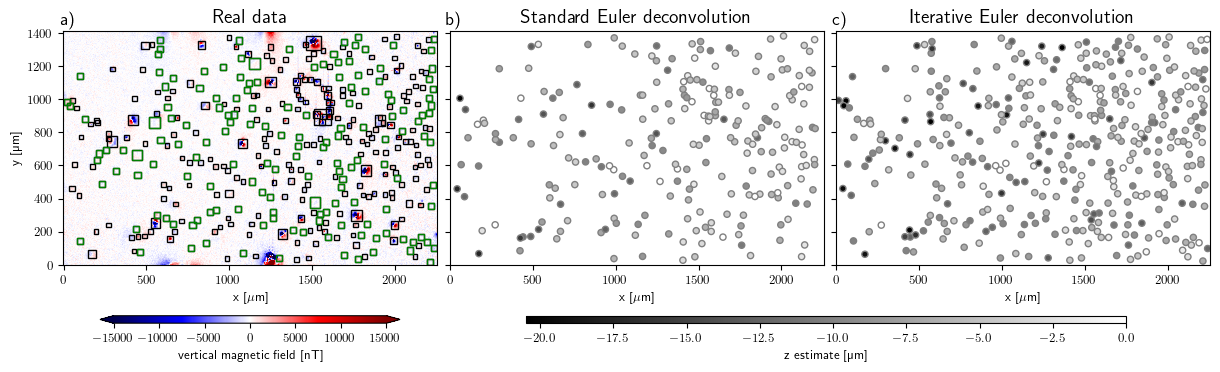

In [63]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    axes = axes.ravel()

    ax = axes[0]
    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=positions_itr_enhanced[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


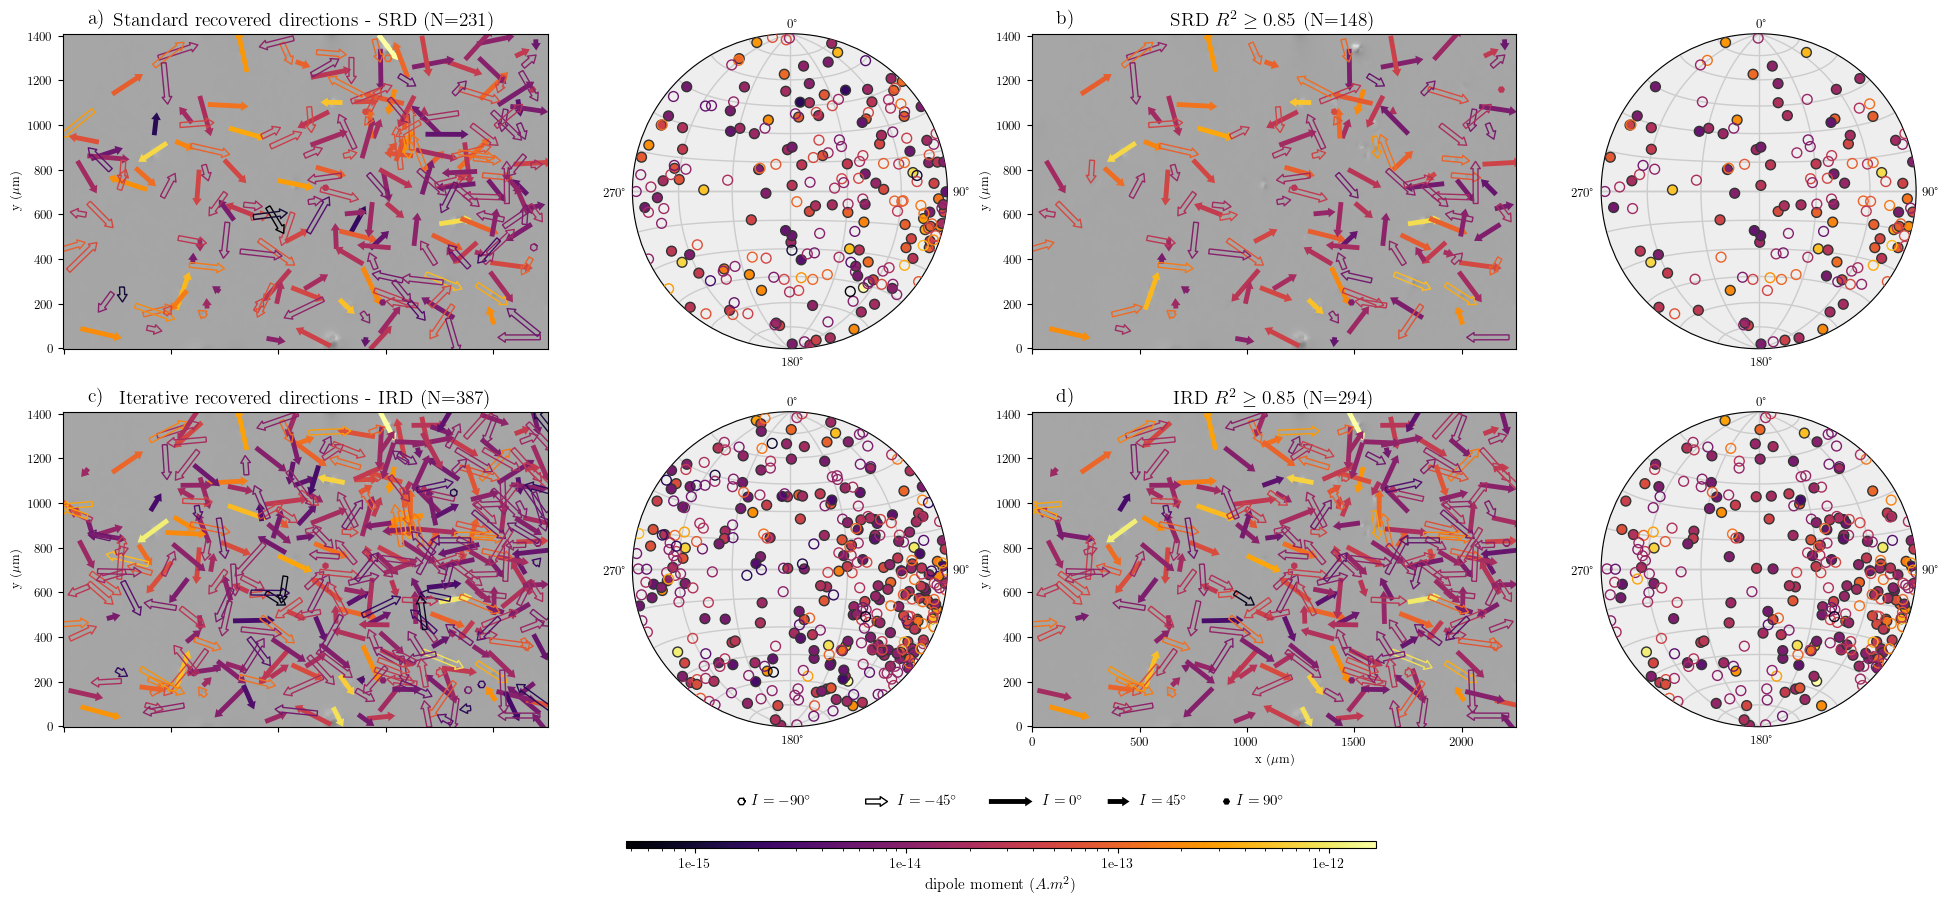

In [65]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

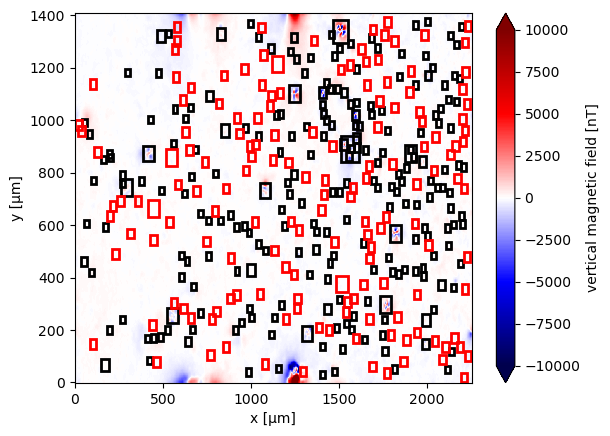

In [66]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [67]:
np.asarray(calculated_r2_itr_euler_enhanced).T

array([ 0.9598822 ,  0.91539328,  0.88373832,  0.92045119,  0.93506367,
        0.99760932,  0.9907331 ,  0.98010788,  0.99774337,  0.96080485,
        0.9890236 ,  0.93479342,  0.99065394,  0.93156256,  0.93225046,
        0.99928165,  0.90702855,  0.9231549 ,  0.99553947,  0.91429688,
        0.97780884,  0.99962294, -0.05020889,  0.99111725,  0.9651801 ,
        0.84702279,  0.58250609,  0.54095895,  0.97954741,  0.94987614,
        0.9443325 ,  0.99619289,  0.1064348 ,  0.95742252,  0.71481015,
        0.98981566,  0.95849278,  0.99550362,  0.93425894,  0.94208736,
        0.94620145,  0.99435948,  0.99820904,  0.96047404,  0.91190562,
        0.97546088,  0.99099399,  0.74702981,  0.79676567,  0.95962669,
        0.88949973,  0.97469022,  0.9746703 ,  0.96890519,  0.7041128 ,
        0.8840692 ,  0.8702048 ,  0.98080034,  0.97993553,  0.99114192,
        0.979202  ,  0.99520611,  0.96847611,  0.98196371,  0.99122001,
        0.97908129,  0.81385235,  0.90065155,  0.72297721,  0.97

# Show the observed and predicted data

In [68]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

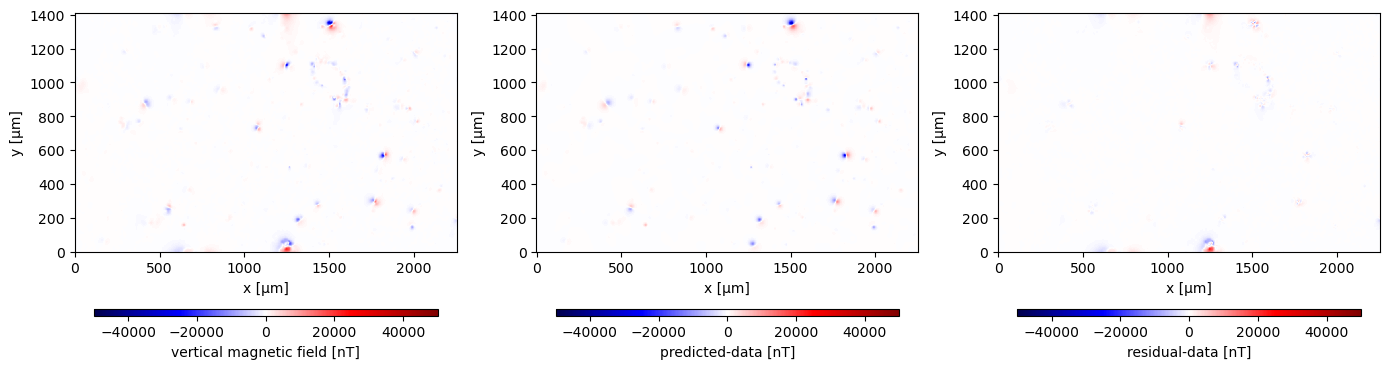

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +50000
    vmin = -50000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

1
Individual source:   R2 = 0.9598821965594293


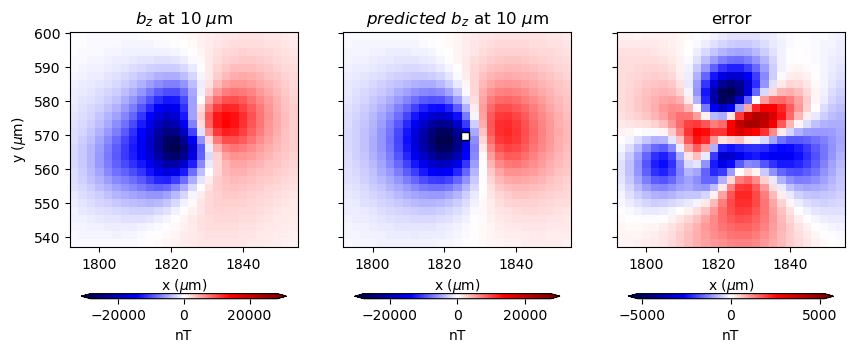

2
Individual source:   R2 = 0.9153932801569843


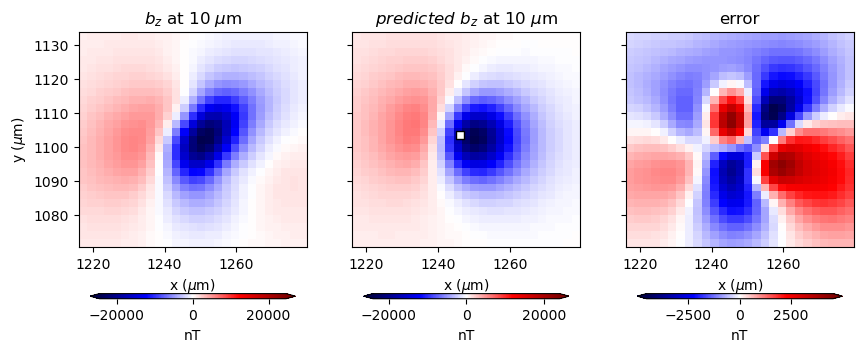

3
Individual source:   R2 = 0.8837383233561058


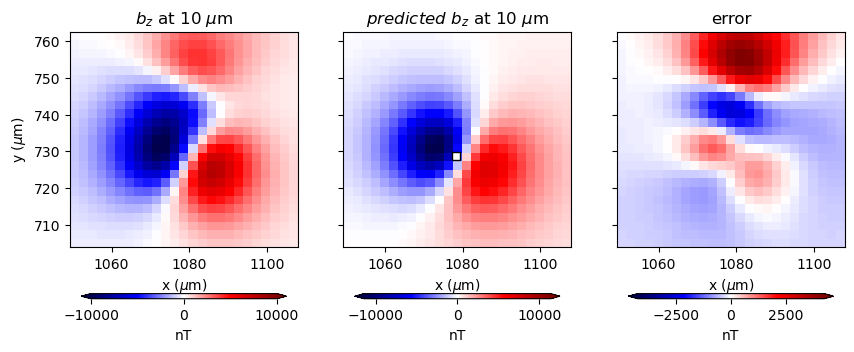

4
Individual source:   R2 = 0.9204511944422288


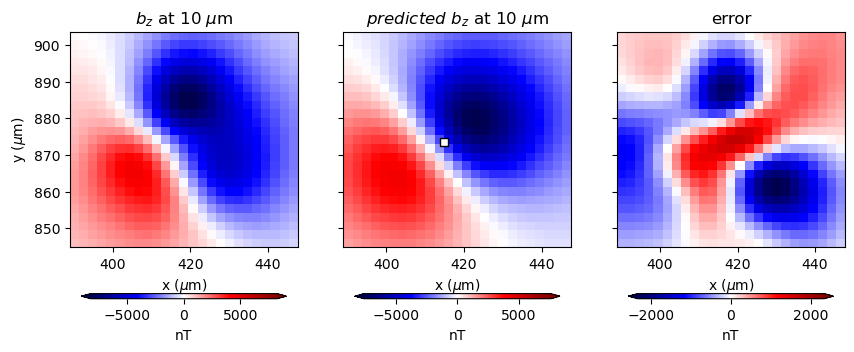

5
Individual source:   R2 = 0.9350636685635345


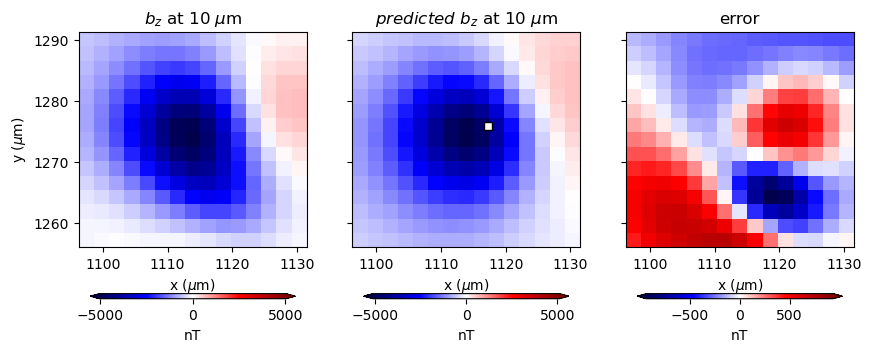

6
Individual source:   R2 = 0.9976093242804156


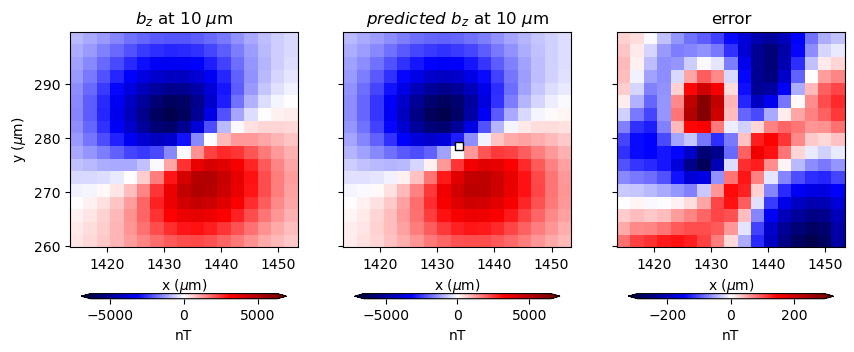

7
Individual source:   R2 = 0.990733103259109


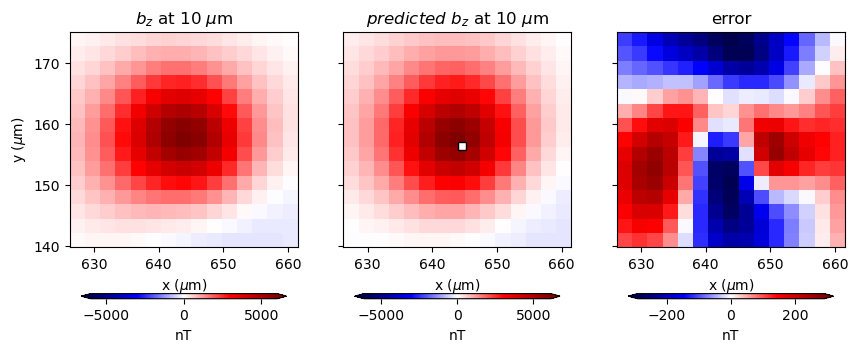

8
Individual source:   R2 = 0.980107884050827


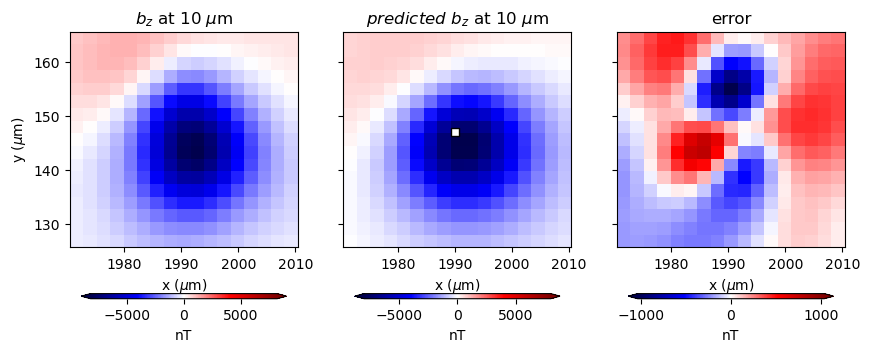

9
Individual source:   R2 = 0.9977433692216976


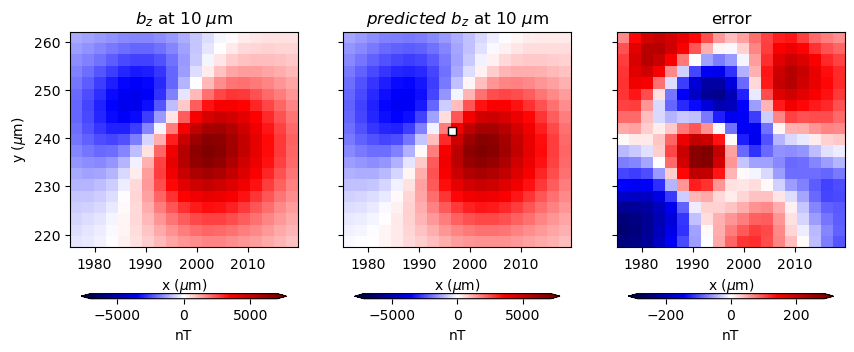

10
Individual source:   R2 = 0.9608048523324298


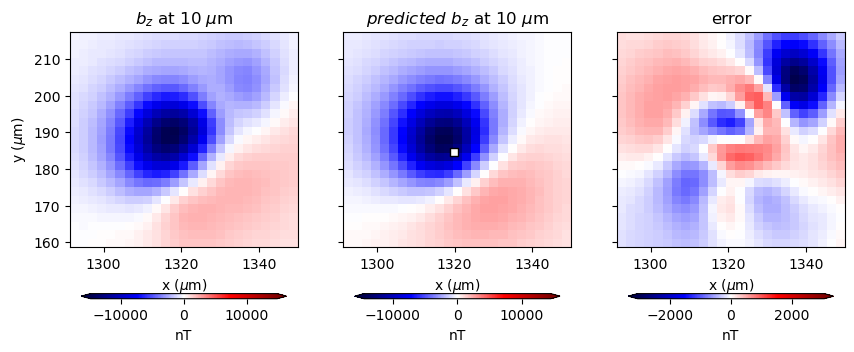

In [70]:
i = 0
slice_start=0#-20
slice_end=10#-1
for window, r2, base_level in zip(windows_enhanced[slice_start:slice_end], 
                                  calculated_r2_itr_euler_enhanced[slice_start:slice_end], 
                                  base_levels_itr_euler_enhanced[slice_start:slice_end]):

    if r2>=-np.inf:
        i=i+1
        print(i)
        # local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        local_data = data_up.copy(deep=True)
        local_data = local_data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
        axes = axes.ravel()    
        cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
        
        ax = axes[0]
        ax.set_aspect("auto")
        ax.set_title(f"$b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        ax.set_ylabel("y ($\mu$m)")
        local_data.bz.values +- base_level
        tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        # ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
        
        ax = axes[1]
        ax.set_aspect("auto")
        ax.set_title(f"$predicted~b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        local_data.predicted_data.values += base_level
        tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.scatter(positions_itr_enhanced[0], positions_itr_enhanced[1], color='w', marker='s', edgecolors='k')
        
        ax = axes[2]   
        ax.set_aspect("auto")
        ax.set_title("error")
        ax.set_xlabel("x ($\mu$m)")
        
        local_data.error.values = local_data.bz.values - local_data.predicted_data.values
        tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
    
        print(r"Individual source:   R2 = %s"%(r2))
    
        plt.show()

In [71]:
# Nome do arquivo ZIP
import os
output_folder = "csv_files_real_data"
os.makedirs(output_folder, exist_ok=True)

In [73]:
# Criar um DataFrame com os vetores
standard_dataframe = pd.DataFrame({
    'xmin': np.asarray(windows)[:, 0],
    'xmax': np.asarray(windows)[:, 1],
    'ymin': np.asarray(windows)[:, 2],
    'ymax': np.asarray(windows)[:, 3],
    'xc_standard': np.asarray(positions)[0, :],
    'yc_standard': np.asarray(positions)[1, :],
    'zc_standard': np.asarray(positions)[2, :],
    'mx_standard': np.asarray(estimated_dipole_moments)[:,0],
    'my_standard': np.asarray(estimated_dipole_moments)[:,1],
    'mz_standard': np.asarray(estimated_dipole_moments)[:,2],
    'r_2_standard': np.asarray(calculated_r2),
})
standard_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_standard.csv'))
standard_dataframe.to_csv(standard_csv_name, index=False)

# Criar DataFrame para os vetores iterativos
iterative_dataframe = pd.DataFrame({
    'xmin': np.asarray(windows_enhanced)[:, 0],
    'xmax': np.asarray(windows_enhanced)[:, 1],
    'ymin': np.asarray(windows_enhanced)[:, 2],
    'ymax': np.asarray(windows_enhanced)[:, 3],
    'xc_iterative': np.asarray(positions_itr_enhanced)[0, :],
    'yc_iterative': np.asarray(positions_itr_enhanced)[1, :],
    'zc_iterative': np.asarray(positions_itr_enhanced)[2, :],
    'mx_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,0],
    'my_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,1],
    'mz_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,2],
    'r_2_iterative': np.asarray(calculated_r2_itr_euler_enhanced),
})

# # Salvar DataFrame iterativo como CSV
iterative_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_iterative.csv'))
iterative_dataframe.to_csv(iterative_csv_name, index=False)